## Data Augmentation

### 引入相關python模組

In [1]:
from mycnn import AlexNet
from mycnn import utils
from mycnn import data
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 自動下載貓狗資料集

從 Microsoft Download Center 下載 Kaggle Cats and Dogs Dataset  
會自動在工作路徑底下建立資料夾，並建立相關的資料集檔案結構  
也會檢查路徑底下是否已經有建立完成檔案，避免重複下載及建立

In [2]:
data.cats_vs_dogs_from_MSCenter('./datasets')

Already download zip file.
Already make dataset.


### 呼叫mycnn.data的資料擴增Dataset實例

利用Keras API中的`preprocessing`模組的`image_dataset_from_directory`  
用此函數來建立貓狗的資料集，此函數將會回傳`tf.data.Dataset`的實例  
接著使用`map`函式來重新縮放(正規化)資料區間至 [0, 1]

```
mycnn.data.generate_classification_dataset

參數名稱            型態    說明
directory        : str   : 資料路徑 (子資料夾為類別)
image_size       : tuple : 影像大小
batch_size       : int   : 批次大小
shuffle_filepath : bool  : 打亂檔案路徑順序
validation_split : float : 分離驗證集的比例
**augdict        : int   : 資料擴增設定
```

In [3]:
augdict = {
    "flip_h": {},
    "flip_v": {},
    "rotate": {},
    "brightness": {"val": 0.95},
    # "hue": {"val": 0.1},
    # "saturation": {"lower": 0.6, "upper": 1.6},
    # "contrast": {"lower": 0.7, "upper": 1.3},
    # "zoom_scale": {"scale_minval": 0.75, "scale_maxval": 1.25},
}

train_dataset, valid_dataset = data.generate_classification_dataset(
    './Datasets/DogsVsCats/train',
    image_size=(227,227),
    batch_size=50,
    subtract_mean=0,
    divide_stddev=255,
    shuffle_filepath=True,
    # shuffle_dataset=True,
    validation_split=0.2,
    # **augdict
)

train_file_paths = train_dataset.file_paths
valid_file_paths = valid_dataset.file_paths

Class indices:
{'Cats': 0, 'Dogs': 1}

Found 24000 files belonging to 2 classes.
Using 19200 files for training.
Using 4800 files for validation.

train - RGB image - Not use data augmentation.
Rescale value to [0.0, 1.0].

valid - RGB image - Not use data augmentation.
Rescale value to [0.0, 1.0].


### 檢查原始資料

./Datasets/DogsVsCats/train\Cats\7485.jpg


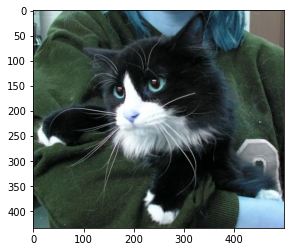

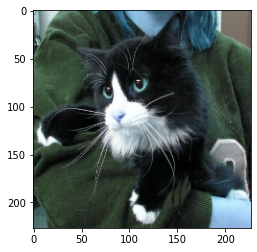

In [4]:
idx = 0
file_path = valid_file_paths[idx]
print(file_path)
image = cv2.imread(file_path)
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (227,227))
plt.imshow(resized_image)
plt.show()

### 載入模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

In [5]:
cnn = AlexNet(classes_num=2)
cnn.summary()

Model: "AlexNet"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image (InputLayer)                                    [(None, 227, 227, 3)]                           0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)                                       (None, 55, 55, 96)                              34944             
________________________________________________________________________________________________________________________
batch_normalization (BatchNormalization)              (None, 55, 55, 96)                              384               
________________________________________________________________________________________________________________________
re_lu (ReLU)   

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小 (註:此設定需與image_dataset_from_directory的批次大小一致)
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

In [6]:
cnn.setup_training(
    'log_alexnet_without_da',
    epochs=20,
    batch_size=50,  # batch size depend on ImageGenerator
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# cbks = [
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss', 
#         factor=0.8, patience=2,
#         min_lr=0.00001,
#         verbose=1
#     ),
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', 
#         patience=10,
#         verbose=1
#     ),
# ]
# cnn.add_callbacks(cbks)

[Info] Create new the directory for training log !!!!!
******************************
Training new model...
******************************
checkpoint_path : log_alexnet_without_da\weights
best_checkpoint : log_alexnet_without_da\weights.h5
epochs          : 20
initial_epoch   : 0
batch_size      : 50
optimizer       : {'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.9, 'nesterov': False}
loss            : categorical_crossentropy
metrics         : ['accuracy']


### 開始訓練

輸入參數分別為訓練資料集、驗證資料集的實例

In [7]:
cnn.train_dataset(train_dataset, valid_dataset)

Epoch 1/20
384/384 [==============================] - 75s 188ms/step - loss: 1.6676 - accuracy: 0.5204 - val_loss: 0.6800 - val_accuracy: 0.5675

Epoch 00001: val_loss improved from inf to 0.68005, saving model to log_alexnet_da\weights.h5
Epoch 2/20
384/384 [==============================] - 71s 185ms/step - loss: 0.6921 - accuracy: 0.5385 - val_loss: 0.6833 - val_accuracy: 0.5692

Epoch 00002: val_loss did not improve from 0.68005
Epoch 3/20
384/384 [==============================] - 72s 188ms/step - loss: 0.6903 - accuracy: 0.5278 - val_loss: 0.6812 - val_accuracy: 0.5627

Epoch 00003: val_loss did not improve from 0.68005
Epoch 4/20
384/384 [==============================] - 73s 190ms/step - loss: 0.6868 - accuracy: 0.5446 - val_loss: 0.6798 - val_accuracy: 0.5685

Epoch 00004: val_loss improved from 0.68005 to 0.67977, saving model to log_alexnet_da\weights.h5
Epoch 5/20
384/384 [==============================] - 72s 189ms/step - loss: 0.6812 - accuracy: 0.5614 - val_loss: 0.7020 

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

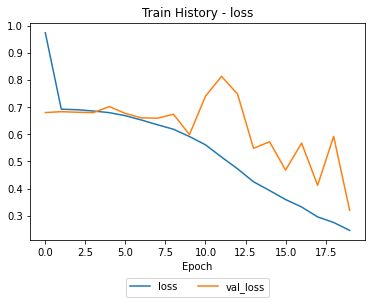

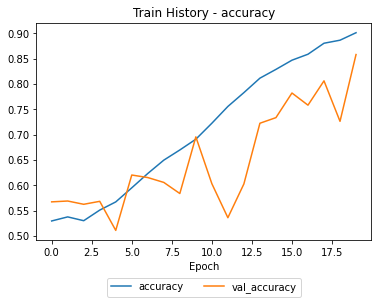

In [7]:
cnn.show_history(["loss", "accuracy"])

### 使用測試資料來確認模型對於新資料的效能

In [9]:
cnn.eval_dataset(valid_dataset)

96/96 [==============================] - 12s 124ms/step - loss: 0.3201 - accuracy: 0.8579


[0.32007500529289246, 0.8579166531562805]

### 使用confusion matrix來更進一步確認分類性能

- 預測測試資料的分數 (基於softmax函數計算機率分布)
- 使用`argmax`將分數轉成類別ID
- 輸出分類報告 (印出confusion matrix、分類報告；輸出完整報表)
- 繪製confusion matrix，分為recall、precision

> Note:  
recall: 召回率，在所有GT中，真正預測出TP的指標  
precision: 精確率，在所有預測結果中，真正為TP的指標  
(GT: 真實情況；TP: 正樣本)

Found 24000 files belonging to 2 classes.
Using 4800 files for validation.


100%|██████████| 4800/4800 [00:00<00:00, 343783.67it/s]


[[1913  482]
 [ 117 2288]] 

              precision    recall  f1-score   support

        Cats       0.94      0.80      0.86      2395
        Dogs       0.83      0.95      0.88      2405

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.87      4800
weighted avg       0.88      0.88      0.87      4800
 



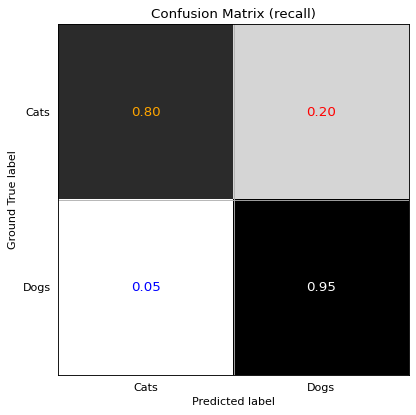

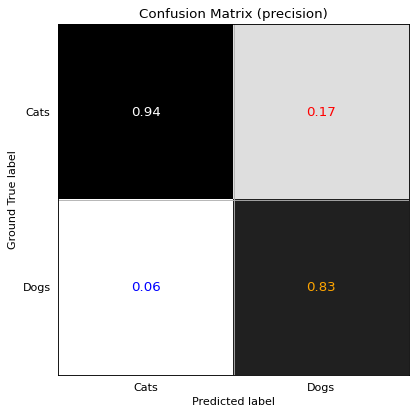

In [10]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(227,227),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
pred_dataset = pred_dataset.map(lambda x, y: (x/255., y))

pr_score = None
pr_label = None
gt_label = None
for ind, batch_set in enumerate(pred_dataset):
    batch_im, batch_gt = batch_set
    batch_pr = cnn.pred(batch_im.numpy())
    if ind == 0:
        pr_score = batch_pr
        pr_label = batch_pr.argmax(axis=-1)
        gt_label = batch_gt.numpy().argmax(axis=-1)
    else:
        pr_score = np.concatenate([pr_score, batch_pr])
        pr_label = np.concatenate([pr_label, batch_pr.argmax(axis=-1)])
        gt_label = np.concatenate([gt_label, batch_gt.numpy().argmax(axis=-1)])

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=cnn.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, cnn.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, cnn.logdir, title='Confusion Matrix (precision)')

### 預測單筆資料

./Datasets/DogsVsCats/train\Cats\7485.jpg


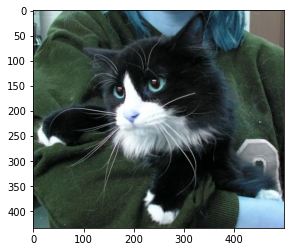

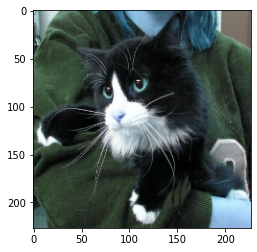

(1, 227, 227, 3, 1)

[Info] Use `tf.keras.Model` method predict

Score:
[1. 0.]
Label: 0


In [11]:
idx = 0

file_path = valid_file_paths[idx]
print(file_path)
image = cv2.imread(file_path)
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (227,227))
plt.imshow(resized_image)
plt.show()

batch_one_image = np.expand_dims(resized_image, axis=0)
batch_one_image = np.expand_dims(batch_one_image, axis=-1)
print(batch_one_image.shape)

pr_sc = cnn.predict(batch_one_image)
pr_lb = pr_sc.argmax(axis=-1)
print("Score:")
print(pr_sc[0])
print("Label:", pr_lb[0])